# Installing the dependencies

In [1]:
!pip install vizdoom

In [42]:
!pip install opencv-python==4.5.5.62

In [ ]:
!pip install gym==0.19.0

In [104]:
!pip install matplotlib==3.5.1 

     ---------------------------------------- 7.2/7.2 MB 547.0 kB/s eta 0:00:00
     -------------------------------------- 55.8/55.8 kB 584.1 kB/s eta 0:00:00
     ---------------------------------------- 2.5/2.5 MB 456.8 kB/s eta 0:00:00
  Using cached fonttools-4.38.0-py3-none-any.whl (965 kB)
     ------------------------------------ 103.1/103.1 kB 540.1 kB/s eta 0:00:00
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)


# Importing the game

In [1]:
from vizdoom import *
import random
import time 
import numpy as np

In [4]:
# Setup game
game = DoomGame()
game.load_config('game/VizDoom/scenarios/basic.cfg')
game.init()

In [3]:
actions=np.identity(3,dtype=np.uint8)

In [5]:
episodes=10
for episode in range(episodes):
    game.new_episode()
    while not game.is_episode_finished():
        state=game.get_state()
        img=state.screen_buffer
        info= state.game_variables
        reward=game.make_action(random.choice(actions),4)
        print('Print', reward)
        time.sleep(0.02)
    print('Result:', game.get_total_reward())
    time.sleep(2)

Print -4.0
Print -4.0
Print -4.0
Print -4.0
Print -4.0
Print -4.0
Print -4.0
Print -4.0
Print -4.0
Print -9.0
Print -4.0
Print -4.0
Print -4.0
Print -9.0
Print -4.0
Print -4.0
Print -4.0
Print -9.0
Print -4.0
Print -4.0
Print -9.0
Print -4.0
Print -4.0
Print -4.0
Print -4.0
Print -4.0
Print -4.0
Print -4.0
Print -9.0
Print -4.0
Print -4.0
Print -4.0
Print -4.0
Print -4.0
Print -9.0
Print -4.0
Print -4.0
Print -9.0
Print -4.0
Print -4.0
Print -4.0
Print -4.0
Print -4.0
Print -4.0
Print -9.0
Print -4.0
Print -4.0
Print -4.0
Print -4.0
Print -9.0
Print -4.0
Print -4.0
Print -9.0
Print -4.0
Print -4.0
Print -4.0
Print -4.0
Print -4.0
Print -4.0
Print -4.0
Print -9.0
Print -4.0
Print -4.0
Print -4.0
Print -4.0
Print -9.0
Print -4.0
Print -4.0
Print -4.0
Print -9.0
Print -4.0
Print -4.0
Print -4.0
Print -4.0
Print -4.0
Result: -365.0
Print -4.0
Print -4.0
Print 99.0
Result: 91.0
Print -4.0
Print -9.0
Print -4.0
Print -4.0
Print -9.0
Print -4.0
Print -4.0
Print -4.0
Print -4.0
Print -4.0


ViZDoomUnexpectedExitException: Controlled ViZDoom instance exited unexpectedly.

In [7]:
game.close()

# Coverting the game to GYM Environment

In [6]:
from gym import Env
from gym.spaces import Discrete, Box
import cv2

In [7]:
class Vizdoom(Env): 
    def __init__(self, render=False): 
        super().__init__()
        self.game = DoomGame()
        self.game.load_config('game/VizDoom/scenarios/basic.cfg')
        if render == False: 
            self.game.set_window_visible(False)
        else:
            self.game.set_window_visible(True)
        self.game.init()
        self.observation_space = Box(low=0, high=255, shape=(100,160,1), dtype=np.uint8) 
        self.action_space = Discrete(3)
        
    def step(self, action):
        actions = np.identity(3)
        reward = self.game.make_action(actions[action], 4) 

        if self.game.get_state(): 
            state = self.game.get_state().screen_buffer
            state = self.grayscale(state)
            ammo = self.game.get_state().game_variables[0]
            info = ammo
        else: 
            state = np.zeros(self.observation_space.shape)
            info = 0 
        info = {"info":info}
        done = self.game.is_episode_finished()
        return state, reward, done, info 
    
    def render(): 
        pass
     
    def reset(self): 
        self.game.new_episode()
        state = self.game.get_state().screen_buffer
        return self.grayscale(state)
    
    def grayscale(self, observation):
        gray = cv2.cvtColor(np.moveaxis(observation, 0, -1), cv2.COLOR_BGR2GRAY)
        resize = cv2.resize(gray, (160,100), interpolation=cv2.INTER_CUBIC)
        state = np.reshape(resize, (100,160,1))
        return state

    def close(self): 
        self.game.close()

In [8]:
env=Vizdoom(render=True)

In [9]:
state=env.reset()

In [10]:
env.close()

# Coverting to the greyscale image

In [11]:
from matplotlib import pyplot as plt

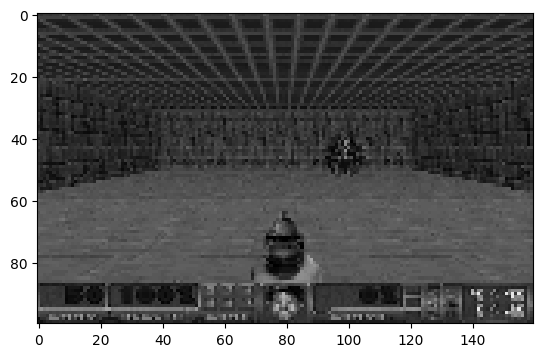

In [12]:
plt.imshow(cv2.cvtColor(state,cv2.COLOR_BGR2RGB))

# Setting up the call back to save the results of the model

In [44]:
!pip install torch torchvision torchaudio

In [45]:
pip install stable-baselines3[extra]==1.3.1a9

Note: you may need to restart the kernel to use updated packages.


In [18]:
import os 
from stable_baselines3.common.callbacks import BaseCallback

In [19]:
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)
        return True

In [12]:
CHECKPOINT_DIR = './train/train_basic'
LOG_DIR = './logs/log_basic'

In [20]:
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

# Training of our model

In [13]:
from stable_baselines3 import PPO

C:\Users\zaoun\anaconda3\envs\mariorl\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
env = Vizdoom()

In [26]:
model = PPO('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, learning_rate=0.0001, n_steps=2048)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [27]:
model.learn(total_timesteps=100000, callback=callback)

Logging to ./logs/log_basic\PPO_4
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 29.3     |
|    ep_rew_mean     | -64.5    |
| time/              |          |
|    fps             | 18       |
|    iterations      | 1        |
|    time_elapsed    | 107      |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 26.8        |
|    ep_rew_mean          | -48.2       |
| time/                   |             |
|    fps                  | 7           |
|    iterations           | 2           |
|    time_elapsed         | 578         |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009133687 |
|    clip_fraction        | 0.172       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | -0.000104 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | 51.5        |
| time/                   |             |
|    fps                  | 3           |
|    iterations           | 11          |
|    time_elapsed         | 6725        |
|    total_timesteps      | 22528       |
| train/                  |             |
|    approx_kl            | 0.015643563 |
|    clip_fraction        | 0.309       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.941      |
|    explained_variance   | 0.637       |
|    learning_rate        | 0.0001      |
|    loss                 | 1.42e+03    |
|    n_updates            | 100         |
|    policy_gradient_loss | 0.00284     |
|    value_loss           | 2.95e+03    |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 8.6   

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 6.41        |
|    ep_rew_mean          | 74.4        |
| time/                   |             |
|    fps                  | 3           |
|    iterations           | 21          |
|    time_elapsed         | 11930       |
|    total_timesteps      | 43008       |
| train/                  |             |
|    approx_kl            | 0.068486445 |
|    clip_fraction        | 0.33        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.62       |
|    explained_variance   | 0.702       |
|    learning_rate        | 0.0001      |
|    loss                 | 309         |
|    n_updates            | 200         |
|    policy_gradient_loss | 0.0321      |
|    value_loss           | 572         |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 5.75  

KeyboardInterrupt: 

# Testing of our model

In [15]:
from stable_baselines3.common.evaluation import evaluate_policy

In [16]:
model = PPO.load('./train/train_basic/best_model_10000')

In [19]:
env = Vizdoom(render=True)

In [20]:
mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=100)

ViZDoomUnexpectedExitException: Controlled ViZDoom instance exited unexpectedly.

In [ ]:
env.close()